In [1]:
import pandas as pd 
from selenium import webdriver
from selenium.webdriver.common.by import By
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import re
import string

In [2]:
n_future = 1
n_past = 5

In [3]:
full_WP = pd.read_csv("./Full WP dataset.csv")

C:\Users\Louis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,2,8,9,14,25,131,132,133,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Data Preprcoessing

In [4]:
full_WP = full_WP.iloc[1:]

In [5]:
full_WP = full_WP.loc[full_WP['SEASON'].astype(int) >= 2000]

In [6]:
columns_features = ['ISO_TIME', 'SEASON', 'NAME', 'USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']

In [7]:
full_WP_modify = full_WP[columns_features].copy()

In [8]:
full_WP_modify

,ISO_TIME,SEASON,NAME,USA_LAT,USA_LON,DIST2LAND,USA_WIND,USA_PRES,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW
196947,2000-05-03 18:00:00,2000,DAMREY,6.20000,135.700,773,25,,,,,,,,,,,,,
196948,2000-05-03 21:00:00,2000,DAMREY,6.77253,135.535,840,25,,,,,,,,,,,,,
196949,2000-05-04 00:00:00,2000,DAMREY,7.30000,135.400,896,25,,,,,,,,,,,,,
196950,2000-05-04 03:00:00,2000,DAMREY,7.74498,135.320,935,25,,,,,,,,,,,,,
196951,2000-05-04 06:00:00,2000,DAMREY,8.10000,135.300,960,25,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239452,2021-09-23 00:00:00,2021,NOT_NAMED,13.5000,111.200,196,29,1003,,,,,,,,,,,,
239453,2021-09-23 03:00:00,2021,NOT_NAMED,13.8697,110.707,151,32,1003,,,,,,,,,,,,
239454,2021-09-23 06:00:00,2021,NOT_NAMED,14.3000,110.200,106,35,1003,90,,,50,,,,,,,,
239455,2021-09-23 09:00:00,2021,NOT_NAMED,14.7481,109.586,53,35,1002,60,,,40,,,,,,,,


In [9]:
full_WP_modify = full_WP_modify.reset_index(drop=True)

In [10]:
full_WP_modify = full_WP_modify[full_WP_modify.NAME != 'NOT_NAMED']

In [11]:
full_WP_modify = full_WP_modify.reset_index(drop=True)

In [12]:
full_WP_modify = full_WP_modify[full_WP_modify.USA_LAT!=' ']

In [13]:
full_WP_modify = full_WP_modify.replace(r'^\s*$', -1 , regex=True)

In [14]:
full_WP_modify['USA_LAT'] = full_WP_modify['USA_LAT'].astype(float)

In [15]:
full_WP_modify['USA_LON'] = full_WP_modify['USA_LON'].astype(float)

In [16]:
full_WP_modify = full_WP_modify.reset_index(drop=True)

In [17]:
full_WP_modify['USA_LAT'].min()

1.3

In [18]:
full_WP_modify['USA_LAT'].max()

51.3

In [19]:
full_WP_modify['USA_LON'].min()

-180.0

In [20]:
full_WP_modify['USA_LON'].max()

180.0

In [21]:
full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index]

344     -178.000
345     -178.100
346     -178.200
347     -178.325
348     -178.600
          ...   
27063   -177.186
27064   -178.000
27065   -178.735
27066   -179.500
28929   -179.900
Name: USA_LON, Length: 971, dtype: float64

In [22]:
full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] = full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] + 360

C:\Users\Louis\AppData\Local\Temp/ipykernel_10588/916726116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] = full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] + 360


In [23]:
# full_WP_modify = full_WP_modify.drop(full_WP_modify[full_WP_modify.USA_LON < 0].index)

In [24]:
full_WP_modify['USA_LON'].max()

244.9

In [25]:
full_WP_modify['USA_LON'].min()

78.6

In [26]:
long_range = full_WP_modify.index[full_WP_modify['USA_LON'] <0].tolist()

In [27]:
len(long_range)

0

In [28]:
dict_remove = {}
for i in long_range:
    print(i)
    name = full_WP_modify.iloc[i,2]
    year = full_WP_modify.iloc[i,1]
    dict_remove[year] = name

In [29]:
dict_remove

{}

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler_lat = MinMaxScaler()
scaler_long = MinMaxScaler()
scaler_dist = MinMaxScaler()
scaler_wind = MinMaxScaler()
scaler_pres = MinMaxScaler()
scaler_r34_ne = MinMaxScaler()
scaler_r34_se = MinMaxScaler()
scaler_r34_sw = MinMaxScaler()
scaler_r34_nw = MinMaxScaler()
scaler_r50_ne = MinMaxScaler()
scaler_r50_se = MinMaxScaler()
scaler_r50_sw = MinMaxScaler()
scaler_r50_nw = MinMaxScaler()
scaler_r64_ne = MinMaxScaler()
scaler_r64_se = MinMaxScaler()
scaler_r64_sw = MinMaxScaler()
scaler_r64_nw = MinMaxScaler()

In [31]:
full_WP_modify[['USA_LAT']] = scaler_lat.fit_transform(full_WP_modify[['USA_LAT']])
full_WP_modify[['USA_LON']] = scaler_long.fit_transform(full_WP_modify[['USA_LON']])
full_WP_modify[['DIST2LAND']] = scaler_dist.fit_transform(full_WP_modify[['DIST2LAND']])
full_WP_modify[['USA_WIND']] = scaler_wind.fit_transform(full_WP_modify[['USA_WIND']])
full_WP_modify[['USA_PRES']] = scaler_pres.fit_transform(full_WP_modify[['USA_PRES']])
full_WP_modify[['USA_R34_NE']] = scaler_r34_ne.fit_transform(full_WP_modify[['USA_R34_NE']])
full_WP_modify[['USA_R34_SE']] = scaler_r34_se.fit_transform(full_WP_modify[['USA_R34_SE']])
full_WP_modify[['USA_R34_SW']] = scaler_r34_sw.fit_transform(full_WP_modify[['USA_R34_SW']])
full_WP_modify[['USA_R34_NW']] = scaler_r34_nw.fit_transform(full_WP_modify[['USA_R34_NW']])
full_WP_modify[['USA_R50_NE']] = scaler_r50_ne.fit_transform(full_WP_modify[['USA_R50_NE']])
full_WP_modify[['USA_R50_SE']] = scaler_r50_se.fit_transform(full_WP_modify[['USA_R50_SE']])
full_WP_modify[['USA_R50_SW']] = scaler_r50_sw.fit_transform(full_WP_modify[['USA_R50_SW']])
full_WP_modify[['USA_R50_NW']] = scaler_r50_nw.fit_transform(full_WP_modify[['USA_R50_NW']])
full_WP_modify[['USA_R64_NE']] = scaler_r64_ne.fit_transform(full_WP_modify[['USA_R64_NE']])
full_WP_modify[['USA_R64_SE']] = scaler_r64_se.fit_transform(full_WP_modify[['USA_R64_SE']])
full_WP_modify[['USA_R64_SW']] = scaler_r64_sw.fit_transform(full_WP_modify[['USA_R64_SW']])
full_WP_modify[['USA_R64_NW']] = scaler_r64_nw.fit_transform(full_WP_modify[['USA_R64_NW']])

In [32]:
for year in range(2000,2022):
     globals()['df_WP_%s' % year] = full_WP_modify[(full_WP_modify["SEASON"]==year)]

In [33]:
for year in range(2000,2022):
    globals()['df_WP_%s' % year] = globals()['df_WP_%s' % year].reset_index(drop=True)

In [34]:
for year in range(2000,2022):
    globals()['df_WP_%s' % year] =  globals()['df_WP_%s' % year].drop(['SEASON'], axis=1)

In [35]:
for year in range(2000,2022):
    for i in range(len(globals()['df_WP_%s' % year])):
        globals()['df_WP_%s' % year].iloc[i,1] = re.sub(r"[^\w\s]", '',  globals()['df_WP_%s' % year].iloc[i,1])

In [36]:
summarylist = []
for year in range(2000,2022):
    summarylist.append(dict(tuple(globals()['df_WP_%s' % year].groupby('NAME'))))

In [37]:
tc_name_list = []
for i in range(len(summarylist)):
    tc_name_list.append(list(summarylist[i].keys()))

In [38]:
print(tc_name_list[0])

['BEBINCA', 'BILIS', 'BOLAVEN', 'BOPHA', 'CHANCHU', 'DAMREY', 'EWINIAR', 'JELAWAT', 'KAEMI', 'KAITAK', 'KIROGI', 'LONGWANG', 'MARIA', 'PRAPIROON', 'RUMBIA', 'SAOMAI', 'SHANSHAN', 'SONAMU', 'SOULIK', 'TEMBIN', 'WENE', 'WUKONG', 'XANGSANE', 'YAGI']


In [39]:
count = 0
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        count = count+1
        globals()['df_WP_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s' % (str(2000+i))][globals()['df_WP_%s' % (str(2000+i))].NAME == name]
#         globals()['df_WP_%s_%s'%((str(2000+i)), name)]  = globals()['df_WP_%s_%s'%((str(2000+i)), name)][globals()['df_WP_%s_%s'%((str(2000+i)),name)].USA_LAT != ' ']
        globals()['df_WP_%s_%s'%((str(2000+i)), name)]  = globals()['df_WP_%s_%s'%((str(2000+i)), name)] .reset_index(drop=True)

In [40]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        globals()['df_WP_%s_%s'%((str(2000+i)), name)] = (globals()['df_WP_%s_%s'%((str(2000+i)), name)]).drop(['NAME'], axis=1)

In [41]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        globals()['df_WP_%s_%s'%((str(2000+i)), name)].rename(columns={'ISO_TIME':'Date'}, inplace=True)
        globals()['df_WP_%s_%s'%((str(2000+i)), name)]['Date'] = pd.to_datetime(globals()['df_WP_%s_%s'%((str(2000+i)), name)]['Date'], dayfirst=True)

In [42]:
cols_features = list(df_WP_2018_MANGKHUT)[1:len(df_WP_2018_MANGKHUT.columns)]
print(cols_features)

['USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']


In [43]:
cols_target = list(df_WP_2018_MANGKHUT)[1:2]

In [44]:
cols_target

['USA_LAT']

In [45]:
print(cols_features)
print(cols_target)

['USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']
['USA_LAT']


In [46]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        globals()['df_features_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_features].astype(float)
        globals()['df_target_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_target].astype(float)

### Augmented Dickey Fuller test

In [47]:
# from statsmodels.tools.sm_exceptions import (
#     CollinearityWarning,
#     InfeasibleTestError,
#     InterpolationWarning,
#     MissingDataError,
# )

In [48]:
# features = list(df_WP_2018_MANGKHUT)[1:]

In [49]:
# features

In [50]:
# def Average(lst):
#     return sum(lst) / len(lst)

# def Minimum(lst):
#     return min(lst)

In [51]:
# from statsmodels.tsa.stattools import adfuller
# np.seterr(divide = 'ignore') 

# for feature in features:
#     locals()["adf"+feature] = []

# for i in range(len(tc_name_list)):
#     for name in tc_name_list[i]:
#         for feature in features:
#             # print("Stationary test of ", feature)
#             df_adf = globals()['df_WP_%s_%s'%((str(2000+i)), name)][[feature]]
#             # df_adf_lat.plot(figsize=(8,4))
#             # plt.show()
#             adf = adfuller(df_adf)
#             # print(adf[1])
#             if np.isnan(adf[1])== True:
#                 temp_list = list(adf)
#                 temp_list[1] = 0
#                 adf = tuple(temp_list)
#                 locals()["adf"+feature].append(adf[1])
#             else:
#                 locals()["adf"+feature].append(adf[1])
#             # print("ADF Stat: " , adf[0])
#             # print("P-value: " , adf[1])
#             # print("Critical Value: " , adf[4])
#             # print("\n")

In [52]:
# print("Threshold : 0.05 ")
# for feature in features:
#     print("Average P-value of ADF test of each", feature, "in all typhoon data :", Average(locals()["adf"+feature]))
# print("\n") 
# for feature in features:
#     print("Minimum P-value of ADF test of each", feature, "in all typhoon data :", Minimum(locals()["adf"+feature]))

P-value is greater than significant level of 0.05, all variables are individually non stationary, therefore, pass to cointegration test to check whether residual of two variables has a long term stationary property.

### Cointegration test

In [53]:
# import statsmodels.tsa.stattools as ts
# for feature in features:
#     locals()["coin_lat_"+feature] = []
#     locals()["coin_lon_"+feature] = []

# for i in range(len(tc_name_list)):
#     for name in tc_name_list[i]:    
#         for feature in features:
#             # print("Cointegration test between USA LAT and", feature)
#             coin_result = ts.coint(globals()['df_WP_%s_%s'%((str(2000+i)), name)]["USA_LAT"], globals()['df_WP_%s_%s'%((str(2000+i)), name)][feature])
#             locals()["coin_lat_"+feature].append(coin_result[1])
#             # print("t-statistics of unit root test: ", coin_result[0])
#             # print("p-value: ", coin_result[1])
#             # print("critical values of 1%m 5% and 10%: ",coin_result[2])
#             # print("\n")

# print("----------------------------------------------------------------------------------")

# for i in range(len(tc_name_list)):
#     for name in tc_name_list[i]:    
#         for feature in features:
#             # print("Cointegration test between USA LON and", feature)
#             coin_result = ts.coint(globals()['df_WP_%s_%s'%((str(2000+i)), name)]["USA_LON"], globals()['df_WP_%s_%s'%((str(2000+i)), name)][feature])
#             locals()["coin_lon_"+feature].append(coin_result[1])
#             # print("t-statistics of unit root test: ", coin_result[0])
#             # print("p-value: ", coin_result[1])
#             # print("critical values of 1%m 5% and 10%: ",coin_result[2])
#             # print("\n")

In [54]:
# print("Threshold : 0.05 ")
# for feature in features:
#     print("Average P-value of Cointegration test between Latitude and", feature, "in all typhoon data :", Average(locals()["coin_lat_"+feature]))
# print("\n") 

# for feature in features:
#     print("Average P-value of Cointegration test between Longitude and", feature, "in all typhoon data :", Average(locals()["coin_lon_"+feature]))
# print("\n") 

# for feature in features:
#     print("Minimum P-value of Cointegration test between Latitude and", feature, "in all typhoon data :", Minimum(locals()["coin_lat_"+feature]))

# print("\n") 
# for feature in features:    
#     print("Minimum P-value of Cointegration test between Longitude and", feature, "in all typhoon data :", Minimum(locals()["coin_lon_"+feature]))

All p-value is greater than 0.05 

no stationary property between latitude, longitude and other meteorological features

Since the sequential data is not stationary, we can expect that there is no granger casuality between any features  to latitude or lonigtude

But we can still proceed the granger causality test to clarity whether the null hypothesis of no granger casusality relationship will be accepted 

### Granger Causality test

In [55]:
# from statsmodels.tsa.stattools import grangercausalitytests

In [56]:
# for feature in features:
#     locals()["gc_lat_"+feature] = []

# for i in range(len(tc_name_list)):
#     for name in tc_name_list[i]:
#         for feature in features:
#             # print("Result: ", features[0], "and", feature) 
#             df_granger = globals()['df_WP_%s_%s'%((str(2000+i)), name)][[features[0], feature]]
#             # df_granger = df_WP_2018_WUKONG[[features[0], feature]]
#             try:
#                 ### 5 lags trial ### 
#                 gc_result = grangercausalitytests(df_granger, 5, verbose=False)
#                 p_value = gc_result[5][0]['ssr_ftest'][1]
#                 locals()["gc_lat_"+feature].append(p_value)
#             except InfeasibleTestError:
#                 print("The x values include a column with constant values and so the test statistic cannot be computed.")
#             except ValueError:
#                 continue
#             print("-----------------------------------------------------------------------------------")

In [57]:
# print("Threshold : 0.05 ")
# for feature in features:
#     print("Average P-value of Granger causality test in 5 lags between Latitude and", feature, "in all typhoon data :", Average(locals()["gc_lat_"+feature]))
# print("\n") 
# for feature in features:
#     print("Minimum P-value of Granger causality test in 5 lags between Latitude and", feature, "in all typhoon data :", Minimum(locals()["gc_lat_"+feature]))

In [58]:
# for feature in features:
#     locals()["gc_long_"+feature] = []

# for i in range(len(tc_name_list)):
#     for name in tc_name_list[i]:
#         for feature in features:
#             # print("Result: ", features[0], "and", feature) 
#             df_granger = globals()['df_WP_%s_%s'%((str(2000+i)), name)][[features[1], feature]]
#             # df_granger = df_WP_2018_WUKONG[[features[0], feature]]
#             try:
#                 ### 5 lags trial ### 
#                 gc_result = grangercausalitytests(df_granger, 5, verbose=False)
#                 p_value = gc_result[5][0]['ssr_ftest'][1]
#                 locals()["gc_long_"+feature].append(p_value)
#             except InfeasibleTestError:
#                 print("The x values include a column with constant values and so the test statistic cannot be computed.")
#             except ValueError:
#                 continue
#             print("-----------------------------------------------------------------------------------")

In [59]:
# print("Threshold : 0.05 ")
# for feature in features:
#     print("Average P-value of Granger causality test in 5 lags between Longitude and", feature, "in all typhoon data :", Average(locals()["gc_long_"+feature]))
# print("\n") 
# for feature in features:
#     print("Minimum P-value of Granger causality test in 5 lags between Longitude and", feature, "in all typhoon data :", Minimum(locals()["gc_long_"+feature]))

Based on the p-value obtained from F-test, all values are greater than the significance level of 0.05, we are failed to reject the null hypothesis. We can conclude that there is no granger causality relationship between any meteorological features and latitude, longitude

### Latitude Prediction

In [60]:
tc_name_list[18].remove('MANGKHUT')

In [61]:
tc_name_list[18].remove('KONGREY')

In [62]:
tc_name_list[18].remove('YUTU')

In [63]:
tc_name_list[19].remove('WUTIP')

In [64]:
cols_target = list(df_WP_2018_MANGKHUT)[1:2]

In [65]:
cols_target

['USA_LAT']

In [66]:
print(cols_features)
print(cols_target)

['USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']
['USA_LAT']


In [67]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        globals()['df_features_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_features].astype(float)
        globals()['df_target_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_target].astype(float)

In [68]:
trainX_lat = []
trainY_lat = []
valX_lat = []
valY_lat = []
testX_lat = []
testY_lat = []

In [69]:
for i in range(len(tc_name_list)): ### 20 years of data for training (2000-2020)
    for name in tc_name_list[i]:
        globals()['df_features_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_features_lat_%s_%s'%((str(2000+i)), name)].to_numpy()
        globals()['df_target_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_target_lat_%s_%s'%((str(2000+i)), name)].to_numpy()

In [70]:
dict_name = {}
count = 0
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
            for j in range(n_past, len(globals()['df_features_lat_%s_%s'%((str(2000+i)), name)])-n_future+1):
                trainX_lat.append(globals()['df_features_lat_%s_%s'%((str(2000+i)), name)][j-n_past:j,0:globals()['df_features_lat_%s_%s'%((str(2000+i)), name)].shape[1]])
                trainY_lat.append(globals()['df_target_lat_%s_%s'%((str(2000+i)), name)][j+n_future-1:j+n_future,0])
                dict_name[count] = name
                count +=1

In [71]:
dict_name[22965]

'BANYAN'

In [72]:
count_list = []

for i in range(19,22):
    print(i)
    count_list.append(len(tc_name_list[i]))

19
20
21


In [73]:
sum(count_list)

64

In [74]:
len(tc_name_list[19])

26

In [75]:
trainX_lat = np.array(trainX_lat)

In [76]:
trainX_lat[0]

array([[0.094     , 0.34576067, 0.23662681, 0.12280702, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.0938598 , 0.34021046, 0.23631215, 0.13450292, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.1       , 0.33553818, 0.25550661, 0.15204678, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.1159446 , 0.33226097, 0.25676526, 0.15204678, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.134     , 0.32952495, 0.23694147, 0.152046

In [77]:
trainX_lat.shape

(28712, 5, 17)

In [78]:
trainX_lat, trainY_lat= np.array(trainX_lat), np.array(trainY_lat)
valX_lat, valY_lat= np.array(valX_lat), np.array(valY_lat)
testX_lat, testY_lat= np.array(testX_lat), np.array(testY_lat)

# shuffle_idx
# import random
# shuffle_idx= random.shuffle([i for i in range(10000)])
# trainX = trainX[shuffle_idx]
# trainY = trainY[shuffle_idx]

In [79]:
print(trainX_lat.shape)
print(trainY_lat.shape)
print(valX_lat.shape)
print(valY_lat.shape)
print(testX_lat.shape)
print(testY_lat.shape)

(28712, 5, 17)
(28712, 1)
(0,)
(0,)
(0,)
(0,)


In [80]:
trainX_lat, valX_lat = trainX_lat[:(int(len(trainX_lat) * 0.8)),:,:], trainX_lat[(int(len(trainX_lat) * 0.8)):,:,:]

In [81]:
trainY_lat, valY_lat = trainY_lat[:(int(len(trainY_lat) * 0.8)),:], trainY_lat[(int(len(trainY_lat) * 0.8)):,:]

In [82]:
valX_lat, testX_lat = valX_lat[:(int(len(valX_lat) * 0.5)),:,:], valX_lat[(int(len(valX_lat) * 0.5)):,:,:]

In [83]:
valY_lat, testY_lat = valY_lat[:(int(len(valY_lat) * 0.5)),:], valY_lat[(int(len(valY_lat) * 0.5)):,:]

In [84]:
# from sklearn.model_selection import train_test_split

# trainX_lat, valX_lat, trainY_lat, valY_lat = train_test_split(trainX_lat,trainY_lat,test_size=0.20, random_state=42)
# valX_lat, testX_lat, valY_lat, testY_lat = train_test_split(valX_lat,valY_lat,test_size=0.50, random_state=42)

In [85]:
print(trainX_lat.shape)
print(trainY_lat.shape)
print(valX_lat.shape)
print(valY_lat.shape)
print(testX_lat.shape)
print(testY_lat.shape)

(22969, 5, 17)
(22969, 1)
(2871, 5, 17)
(2871, 1)
(2872, 5, 17)
(2872, 1)


In [86]:
testX_lat[0]

array([[0.382     , 0.38785328, 0.5129012 , 0.73684211, 0.92512315,
        0.35483871, 0.23433875, 0.17570499, 0.21524664, 0.32835821,
        0.23611111, 0.19902913, 0.25888325, 0.26470588, 0.21487603,
        0.18918919, 0.24074074],
       [0.395156  , 0.38540589, 0.48521082, 0.70760234, 0.93103448,
        0.31085044, 0.23433875, 0.164859  , 0.21524664, 0.28855721,
        0.23611111, 0.18446602, 0.24365482, 0.24264706, 0.21487603,
        0.16216216, 0.24074074],
       [0.408     , 0.38304269, 0.45877911, 0.67836257, 0.93694581,
        0.26686217, 0.23433875, 0.15401302, 0.21524664, 0.25373134,
        0.23611111, 0.17475728, 0.23350254, 0.22794118, 0.21487603,
        0.14414414, 0.24074074],
       [0.419146  , 0.38182201, 0.43864065, 0.64912281, 0.93990148,
        0.27272727, 0.23433875, 0.15835141, 0.21973094, 0.26368159,
        0.24537037, 0.18446602, 0.24365482, 0.22794118, 0.23140496,
        0.16216216, 0.24074074],
       [0.43      , 0.38123873, 0.41818754, 0.619883

In [87]:
type(trainX_lat)

numpy.ndarray

In [88]:
trainX_lat.shape[1]

5

In [89]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [90]:
trainX_lat = torch.from_numpy(trainX_lat).float().to(device)
trainY_lat = torch.from_numpy(trainY_lat).float().to(device)
valX_lat = torch.from_numpy(valX_lat).float().to(device)
valY_lat = torch.from_numpy(valY_lat).float().to(device)
testX_lat = torch.from_numpy(testX_lat).float().to(device)
testY_lat = torch.from_numpy(testY_lat).float().to(device)

In [91]:
trainX_lat[0].shape

torch.Size([5, 17])

In [92]:
trainY_lat[0]

tensor([0.1458], device='cuda:0')

In [93]:
from torch.utils.data import TensorDataset, DataLoader

train = TensorDataset(trainX_lat, trainY_lat)
val = TensorDataset(valX_lat, valY_lat)
test = TensorDataset(testX_lat, testY_lat)

# # shuffle = true
# train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
# val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader_one = DataLoader(test, batch_size=1, shuffle=True, drop_last=True)

In [94]:
train[0]

(tensor([[0.0940, 0.3458, 0.2366, 0.1228, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0939, 0.3402, 0.2363, 0.1345, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1000, 0.3355, 0.2555, 0.1520, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1159, 0.3323, 0.2568, 0.1520, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1340, 0.3295, 0.2369, 0.1520, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
        device='cuda:0'),
 tensor([0.1458], device='cuda:0'))

In [95]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # print(out.shape)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]
        
        # print(out.shape)

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [96]:
validation_list_lat = []

In [97]:
class Optimization_Lat:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()
        
        x = x.to(device)
        y = y.to(device)

        
#         print(x.shape)
#         print("y:", y)
        
        
        # Makes predictions
        yhat = self.model(x)

        # print("yhat:", yhat)
        
        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size, n_epochs, n_features):
        # model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        
        model_path = "model_lat"
        previous_validation_loss = 100
        patience = 4
        count = 0
        
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, n_past, n_features])
                # print("X batch after view" , x_batch)
                # print("y batch", y_batch)
                y_batch = y_batch
                
                ## y_batch_class = label_conversion(y_batch)  -> define max, min, nbins
                
                
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, n_past , n_features])
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.8f}\t Validation loss: {validation_loss:.8f}")
                validation_list_lat.append(validation_loss)
                validation_list_lat.sort()
                if validation_loss <= validation_list_lat[0]:
                    torch.save(self.model, model_path)
                    print("Updated best model")
                if validation_loss > previous_validation_loss:
                    count +=1
                    print("Current Validation_loss is greater than Previous Validation Loss, counting:", count)
                    if count>=patience:
                        print("Early stopping executed!")
                        break
                else:
                    print("Continue progress to global minima")
                    count = 0
                previous_validation_loss = validation_loss 

        # torch.save(self.model.state_dict(), model_path)
    
#     def evaluate(self, test_loader, batch_size=1, n_features=1):
#         with torch.no_grad():
#             predictions = []
#             values = []
#             for x_test, y_test in test_loader:
#                 x_test = x_test.view([batch_size, 5, n_features])
#                 y_test = y_test
#                 self.model.eval()
#                 yhat = self.model(x_test)
#                 predictions.append(yhat.detach().numpy())
#                 values.append(y_test.detach().numpy())

#         return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [98]:
def get_model(model, model_params):
    models = {"lstm": LSTMModel}
    return models.get(model.lower())(**model_params)

Batch:  8    Hidden dim:  16   Learning rate:  0.001
[1/100] Training loss: 0.00275745	 Validation loss: 0.00023744
Updated best model
Continue progress to global minima
[2/100] Training loss: 0.00015162	 Validation loss: 0.00013337
Updated best model
Continue progress to global minima
[3/100] Training loss: 0.00008752	 Validation loss: 0.00014401
Current Validation_loss is greater than Previous Validation Loss, counting: 1
[4/100] Training loss: 0.00003654	 Validation loss: 0.00001968
Updated best model
Continue progress to global minima
[5/100] Training loss: 0.00002054	 Validation loss: 0.00001659
Updated best model
Continue progress to global minima
[6/100] Training loss: 0.00001613	 Validation loss: 0.00001380
Updated best model
Continue progress to global minima
[7/100] Training loss: 0.00001518	 Validation loss: 0.00001242
Updated best model
Continue progress to global minima
[8/100] Training loss: 0.00001341	 Validation loss: 0.00002584
Current Validation_loss is greater than P

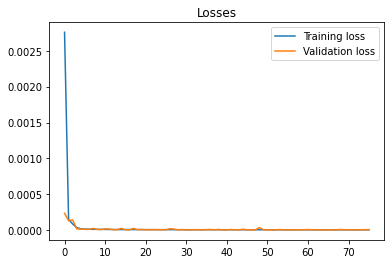

In [100]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# batch_size = 16
input_dim = trainX_lat.shape[2]
output_dim = 1
layer_dim = 1
dropout = 0
n_epochs = 100
# learning_rate = 1e-4
weight_decay = 1e-6

train = TensorDataset(trainX_lat, trainY_lat)
val = TensorDataset(valX_lat, valY_lat)
test = TensorDataset(testX_lat, testY_lat)

batch_size = [8]
hidden_dim = [16]
learning_rate = [0.001]
    
for batch in batch_size:
    for hd in hidden_dim:
        for lr in learning_rate:
            print("Batch: ", batch, " ", " Hidden dim: ", hd, " ", "Learning rate: ", lr)
            # shuffle = true
            train_loader = DataLoader(train, batch_size=batch, shuffle=True, drop_last=True)
            val_loader = DataLoader(val, batch_size=batch, shuffle=True, drop_last=True)
            test_loader = DataLoader(test, batch_size=batch, shuffle=True, drop_last=True)

            model_params = {'input_dim': input_dim,
                            'hidden_dim' : hd,
                            'layer_dim' : layer_dim,
                            'output_dim' : output_dim,
                            'dropout_prob' : dropout }

            model = get_model('lstm', model_params).to(device)
            loss_fn = nn.MSELoss(reduction="mean")
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

            opt_lat = Optimization_Lat(model=model.to(device), loss_fn=loss_fn, optimizer=optimizer)
            opt_lat.train(train_loader, val_loader, batch, n_epochs, input_dim)
            opt_lat.plot_losses()

# predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [99]:
model_lat = torch.load('model_lat')

In [100]:
y_pred_lat = model_lat(testX_lat)

In [101]:
y_pred_lat = y_pred_lat.cpu().detach().numpy()

In [102]:
y_pred_lat_origin = scaler_lat.inverse_transform(y_pred_lat)

In [103]:
testY_lat = testY_lat.cpu().detach().numpy()

In [104]:
y_test_lat_origin = scaler_lat.inverse_transform(testY_lat)

In [105]:
y_test_lat_origin.shape

(2872, 1)

In [106]:
y_pred_lat_origin

array([[23.343637],
       [23.972698],
       [24.641703],
       ...,
       [22.728806],
       [23.510485],
       [23.846895]], dtype=float32)

In [107]:
# import MSE for accurarcy metrics
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(y_test_lat_origin, y_pred_lat_origin))
print(math.sqrt(mean_squared_error(y_test_lat_origin, y_pred_lat_origin)))

0.08436945
0.2904641988396701


In [108]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test_lat_origin, y_pred_lat_origin))
print(math.sqrt(mean_absolute_error(y_test_lat_origin, y_pred_lat_origin)))

0.11279546
0.33585034947714343


### Longitude Prediction

In [109]:
cols_target_long = list(df_WP_2018_MANGKHUT)[2:3]

In [110]:
cols_target_long

['USA_LON']

In [111]:
print(cols_features)
print(cols_target_long)

['USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']
['USA_LON']


In [112]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        globals()['df_features_long_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_features].astype(float)
        globals()['df_target_long_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_target_long].astype(float)

In [113]:
trainX_long = []
trainY_long = []
valX_long = []
valY_long = []
testX_long = []
testY_long = []

In [114]:
for i in range(len(tc_name_list)): ### 20 years of data for training (2000-2020)
    for name in tc_name_list[i]:
        globals()['df_features_long_%s_%s'%((str(2000+i)), name)] = globals()['df_features_long_%s_%s'%((str(2000+i)), name)].to_numpy()
        globals()['df_target_long_%s_%s'%((str(2000+i)), name)] = globals()['df_target_long_%s_%s'%((str(2000+i)), name)].to_numpy()

In [115]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
            for j in range(n_past, len(globals()['df_features_long_%s_%s'%((str(2000+i)), name)])-n_future+1):
                trainX_long.append(globals()['df_features_long_%s_%s'%((str(2000+i)), name)][j-n_past:j,0:globals()['df_features_long_%s_%s'%((str(2000+i)), name)].shape[1]])
                trainY_long.append(globals()['df_target_long_%s_%s'%((str(2000+i)), name)][j+n_future-1:j+n_future,0])

In [116]:
trainX_long, trainY_long= np.array(trainX_long), np.array(trainY_long)
valX_long, valY_long= np.array(valX_long), np.array(valY_long)
testX_long, testY_long= np.array(testX_long), np.array(testY_long)

# shuffle_idx
# import random
# shuffle_idx= random.shuffle([i for i in range(10000)])
# trainX = trainX[shuffle_idx]
# trainY = trainY[shuffle_idx]

In [117]:
print(trainX_long.shape)
print(trainY_long.shape)
print(valX_long.shape)
print(valY_long.shape)
print(testX_long.shape)
print(testY_long.shape)

(28712, 5, 17)
(28712, 1)
(0,)
(0,)
(0,)
(0,)


In [118]:
trainX_long, valX_long = trainX_long[:(int(len(trainX_long) * 0.8)),:,:], trainX_long[(int(len(trainX_long) * 0.8)):,:,:]

In [119]:
trainY_long, valY_long = trainY_long[:(int(len(trainY_long) * 0.8)),:], trainY_long[(int(len(trainY_long) * 0.8)):,:]

In [120]:
valX_long, testX_long = valX_long[:(int(len(valX_long) * 0.5)),:,:], valX_long[(int(len(valX_long) * 0.5)):,:,:]

In [121]:
valY_long, testY_long = valY_long[:(int(len(valY_long) * 0.5)),:], valY_long[(int(len(valY_long) * 0.5)):,:]

In [122]:
# trainX_long, valX_long, trainY_long, valY_long = train_test_split(trainX_long,trainY_long,test_size=0.20, random_state=42)
# valX_long, testX_long, valY_long, testY_long = train_test_split(valX_long,valY_long,test_size=0.50, random_state=42)

In [123]:
print(trainX_long.shape)
print(trainY_long.shape)
print(valX_long.shape)
print(valY_long.shape)
print(testX_long.shape)
print(testY_long.shape)

(22969, 5, 17)
(22969, 1)
(2871, 5, 17)
(2871, 1)
(2872, 5, 17)
(2872, 1)


In [124]:
trainX_long.shape[1]

5

In [125]:
trainX_long = torch.from_numpy(trainX_long).float().to(device)
trainY_long = torch.from_numpy(trainY_long).float().to(device)
valX_long = torch.from_numpy(valX_long).float().to(device)
valY_long = torch.from_numpy(valY_long).float().to(device)
testX_long = torch.from_numpy(testX_long).float().to(device)
testY_long = torch.from_numpy(testY_long).float().to(device)

In [126]:
validation_list_long = []

In [127]:
class Optimization_Long:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()
        
        x = x.to(device)
        y = y.to(device)
        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size, n_epochs, n_features):   
        model_path = "model_lon"
        previous_validation_loss = 100
        patience = 4
        count = 0
        
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, n_past, n_features])
                y_batch = y_batch
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, n_past, n_features])
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.8f}\t Validation loss: {validation_loss:.8f}")
                validation_list_long.append(validation_loss)
                validation_list_long.sort()
                if validation_loss <= validation_list_long[0]:
                    torch.save(self.model, model_path)
                    print("Updated best model")
                if validation_loss > previous_validation_loss:
                    count +=1
                    print("Current Validation_loss is greater than Previous Validation Loss, counting:", count)
                    if count>=patience:
                        print("Early stopping executed!")
                        break
                else:
                    print("Continue progress to global minima")
                    count = 0
                previous_validation_loss = validation_loss 

        # torch.save(self.model.state_dict(), model_path)
    
#     def evaluate(self, test_loader, batch_size=1, n_features=1):
#         with torch.no_grad():
#             predictions = []
#             values = []
#             for x_test, y_test in test_loader:
#                 x_test = x_test.view([batch_size, 5, n_features])
#                 y_test = y_test
#                 self.model.eval()
#                 yhat = self.model(x_test)
#                 predictions.append(yhat.detach().numpy())
#                 values.append(y_test.detach().numpy())

#         return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

Batch:  8    Hidden dim:  128   Learning rate:  0.001
[1/100] Training loss: 0.00085995	 Validation loss: 0.00025198
Updated best model
Continue progress to global minima
[2/100] Training loss: 0.00007508	 Validation loss: 0.00010943
Updated best model
Continue progress to global minima
[3/100] Training loss: 0.00005230	 Validation loss: 0.00006232
Updated best model
Continue progress to global minima
[4/100] Training loss: 0.00003251	 Validation loss: 0.00001910
Updated best model
Continue progress to global minima
[5/100] Training loss: 0.00001805	 Validation loss: 0.00000730
Updated best model
Continue progress to global minima
[6/100] Training loss: 0.00001602	 Validation loss: 0.00005894
Current Validation_loss is greater than Previous Validation Loss, counting: 1
[7/100] Training loss: 0.00001279	 Validation loss: 0.00000657
Updated best model
Continue progress to global minima
[8/100] Training loss: 0.00001010	 Validation loss: 0.00002384
Current Validation_loss is greater than 

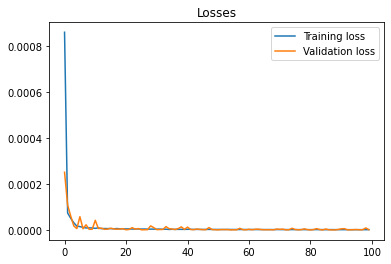

In [130]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

input_dim = trainX_long.shape[2]
output_dim = 1
layer_dim = 1
dropout = 0
n_epochs = 100
# learning_rate = 1e-4
weight_decay = 1e-6

train_long = TensorDataset(trainX_long, trainY_long)
val_long = TensorDataset(valX_long, valY_long)
test_long = TensorDataset(testX_long, testY_long)

batch_size = [8]
hidden_dim = [128]
learning_rate = [0.001]
    
for batch in batch_size:
    for hd in hidden_dim:
        for lr in learning_rate:
            print("Batch: ", batch, " ", " Hidden dim: ", hd, " ", "Learning rate: ", lr)
            # shuffle = true
            train_loader = DataLoader(train_long, batch_size=batch, shuffle=True, drop_last=True)
            val_loader = DataLoader(val_long, batch_size=batch, shuffle=True, drop_last=True)
            test_loader = DataLoader(test_long, batch_size=batch, shuffle=True, drop_last=True)

            model_params = {'input_dim': input_dim,
                            'hidden_dim' : hd,
                            'layer_dim' : layer_dim,
                            'output_dim' : output_dim,
                            'dropout_prob' : dropout }

            model = get_model('lstm', model_params).to(device)
            loss_fn = nn.MSELoss(reduction="mean")
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            opt_lat = Optimization_Long(model=model.to(device), loss_fn=loss_fn, optimizer=optimizer)
            opt_lat.train(train_loader, val_loader, batch, n_epochs, input_dim)
            opt_lat.plot_losses()

In [128]:
model_long = torch.load('model_lon')

In [129]:
y_pred_long = model_long(testX_long)

In [130]:
y_pred_long = y_pred_long.cpu().detach().numpy()

In [131]:
y_pred_long_origin = scaler_long.inverse_transform(y_pred_long)

In [132]:
testY_long = testY_long.cpu().detach().numpy()

In [133]:
y_test_long_origin = scaler_long.inverse_transform(testY_long)

In [134]:
print(mean_squared_error(y_test_long_origin, y_pred_long_origin))
print(math.sqrt(mean_squared_error(y_test_long_origin, y_pred_long_origin)))

0.6369759
0.7981076897496735


In [135]:
pred_2 = np.concatenate((y_pred_lat_origin, y_pred_long_origin), axis=1)

In [136]:
true_2 = np.concatenate((y_test_lat_origin, y_test_long_origin), axis=1)

In [137]:
print(math.sqrt(mean_squared_error(true_2, pred_2)))

0.6005602327133892


### Latitude Prediction (Mangkhut)

In [138]:
df_features_lat_2018_MANGKHUT = df_WP_2018_MANGKHUT[cols_features].astype(float)
df_target_lat_2018_MANGKHUT = df_WP_2018_MANGKHUT[cols_target].astype(float)

df_features_lat_2018_MANGKHUT = df_features_lat_2018_MANGKHUT[cols_features].to_numpy()
df_target_lat_2018_MANGKHUT = df_target_lat_2018_MANGKHUT[cols_target].to_numpy()

X_original_MANGKHURT_lat=[]
Y_original_MANGKHURT_lat=[]

for i in range(n_past, len(df_features_lat_2018_MANGKHUT)-n_future+1):
    X_original_MANGKHURT_lat.append(df_features_lat_2018_MANGKHUT[i-n_past:i,0:df_features_lat_2018_MANGKHUT.shape[1]])
    Y_original_MANGKHURT_lat.append(df_target_lat_2018_MANGKHUT[i+n_future-1:i+n_future,0])
    
X_original_MANGKHURT_lat, Y_original_MANGKHURT_lat= np.array(X_original_MANGKHURT_lat), np.array(Y_original_MANGKHURT_lat)
X_original_MANGKHURT_lat = torch.from_numpy(X_original_MANGKHURT_lat).float()
y_pred_lat_MANGKHURT = model_lat(X_original_MANGKHURT_lat.to(device))
y_pred_lat_MANGKHURT  = y_pred_lat_MANGKHURT.cpu().detach().numpy()
y_pred_lat_MANGKHURT = scaler_lat.inverse_transform(y_pred_lat_MANGKHURT)

y_pred_lat_MANGKHURT_formatted = [ '%.2f' % elem for elem in y_pred_lat_MANGKHURT ]
y_pred_lat_MANGKHURT_formatted = [float(i) for i in y_pred_lat_MANGKHURT_formatted]
print(y_pred_lat_MANGKHURT_formatted)
print(len(y_pred_lat_MANGKHURT_formatted))

Y_original_MANGKHURT_lat = scaler_lat.inverse_transform(Y_original_MANGKHURT_lat)

# import MSE for accurarcy metrics
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(Y_original_MANGKHURT_lat, y_pred_lat_MANGKHURT))
print(math.sqrt(mean_squared_error(Y_original_MANGKHURT_lat, y_pred_lat_MANGKHURT)))

[12.54, 12.76, 13.02, 13.31, 13.56, 13.61, 13.78, 14.16, 14.51, 14.74, 14.91, 15.05, 15.13, 15.25, 15.37, 15.39, 15.37, 15.33, 15.18, 14.92, 14.67, 14.56, 14.46, 14.38, 14.29, 14.2, 14.11, 13.97, 13.91, 13.95, 13.99, 14.02, 14.0, 13.89, 13.87, 13.95, 14.03, 13.99, 14.0, 14.07, 14.15, 14.3, 14.39, 14.4, 14.46, 14.59, 14.69, 14.82, 14.91, 14.97, 15.09, 15.33, 15.61, 15.88, 16.3, 16.85, 17.31, 17.52, 17.74, 17.99, 18.18, 18.24, 18.36, 18.61, 18.86, 19.17, 19.48, 19.74, 20.14, 20.75, 21.27, 21.09, 21.19, 21.25, 21.33, 21.43, 21.53, 21.68, 21.8, 21.93, 22.06, 22.15, 22.25, 22.37, 22.47, 22.94, 23.29, 23.38, 23.5, 23.66]
90
0.0077289004975084966
0.08791416551107391


### Longitude Prediction (Mangkhut)

In [139]:
df_features_long_2018_MANGKHUT = df_WP_2018_MANGKHUT[cols_features].astype(float)
df_target_long_2018_MANGKHUT = df_WP_2018_MANGKHUT[cols_target_long].astype(float)

df_features_long_2018_MANGKHUT = df_features_long_2018_MANGKHUT[cols_features].to_numpy()
df_target_long_2018_MANGKHUT = df_target_long_2018_MANGKHUT[cols_target_long].to_numpy()

X_original_MANGKHURT_long=[]
Y_original_MANGKHURT_long=[]

for i in range(n_past, len(df_features_long_2018_MANGKHUT)-n_future+1):
    X_original_MANGKHURT_long.append(df_features_long_2018_MANGKHUT[i-n_past:i,0:df_features_long_2018_MANGKHUT.shape[1]])
    Y_original_MANGKHURT_long.append(df_target_long_2018_MANGKHUT[i+n_future-1:i+n_future,0])
    
X_original_MANGKHURT_long, Y_original_MANGKHURT_long= np.array(X_original_MANGKHURT_long), np.array(Y_original_MANGKHURT_long)    
X_original_MANGKHURT_long = torch.from_numpy(X_original_MANGKHURT_long).float()
y_pred_long_MANGKHURT = model_long(X_original_MANGKHURT_long.to(device))
y_pred_long_MANGKHURT  = y_pred_long_MANGKHURT.cpu().detach().numpy()
y_pred_long_MANGKHURT = scaler_long.inverse_transform(y_pred_long_MANGKHURT)
y_pred_long_MANGKHURT_formatted = [ '%.2f' % elem for elem in y_pred_long_MANGKHURT ]
y_pred_long_MANGKHURT_formatted = [float(i) for i in y_pred_long_MANGKHURT_formatted]
print(y_pred_long_MANGKHURT_formatted)
print(len(y_pred_long_MANGKHURT_formatted))

Y_original_MANGKHURT_long = scaler_long.inverse_transform(Y_original_MANGKHURT_long)

print(mean_squared_error(Y_original_MANGKHURT_long, y_pred_long_MANGKHURT))
print(math.sqrt(mean_squared_error(Y_original_MANGKHURT_long, y_pred_long_MANGKHURT)))

[166.07, 165.44, 164.8, 163.9, 162.96, 162.38, 161.88, 161.17, 160.26, 159.27, 158.33, 157.16, 156.03, 154.95, 153.87, 153.16, 152.44, 151.39, 150.23, 149.12, 148.16, 147.35, 146.58, 145.65, 144.77, 144.08, 143.45, 142.72, 141.94, 141.16, 140.39, 139.66, 139.0, 138.51, 138.02, 137.3, 136.55, 135.99, 135.51, 135.08, 134.58, 133.94, 133.21, 132.46, 131.75, 131.17, 130.63, 130.04, 129.47, 128.9, 128.35, 127.8, 127.26, 126.79, 126.3, 125.67, 124.94, 124.11, 123.21, 122.24, 121.29, 120.66, 120.13, 119.55, 118.92, 118.25, 117.55, 116.93, 116.26, 115.47, 114.59, 114.4, 114.29, 114.1, 113.85, 113.54, 113.22, 112.86, 112.49, 112.12, 111.75, 111.4, 111.07, 110.2, 109.43, 108.75, 108.05, 107.32, 106.52, 105.62]
90
0.037747219686460116
0.19428643721696096


In [140]:
pred_2_mang = np.concatenate((y_pred_lat_MANGKHURT, y_pred_long_MANGKHURT), axis=1)

In [141]:
true_2_mang = np.concatenate((Y_original_MANGKHURT_lat, Y_original_MANGKHURT_long), axis=1)

In [142]:
print(math.sqrt(mean_squared_error(true_2_mang, pred_2_mang)))

0.15079144568570296


### Prediction visualisation (MANGKHURT)

In [143]:
print("Actual Lat of Mangkhurt:")
Y_original_MANGKHURT_lat_formatted = [ '%.2f' % elem for elem in Y_original_MANGKHURT_lat ]
Y_original_MANGKHURT_lat_formatted = [float(i) for i in Y_original_MANGKHURT_lat_formatted]
print(Y_original_MANGKHURT_lat_formatted)
print(len(Y_original_MANGKHURT_lat_formatted))
print("Actual Long of Mangkhurt:")
Y_original_MANGKHURT_long_formatted = [ '%.2f' % elem for elem in Y_original_MANGKHURT_long ]
Y_original_MANGKHURT_long_formatted = [float(i) for i in Y_original_MANGKHURT_long_formatted]
print(Y_original_MANGKHURT_long_formatted)
print(len(Y_original_MANGKHURT_long_formatted))

Actual Lat of Mangkhurt:
[12.58, 12.8, 13.06, 13.3, 13.44, 13.6, 13.88, 14.2, 14.47, 14.7, 14.87, 15.0, 15.11, 15.2, 15.27, 15.3, 15.29, 15.2, 15.01, 14.8, 14.63, 14.5, 14.39, 14.3, 14.2, 14.1, 13.98, 13.9, 13.88, 13.9, 13.91, 13.9, 13.84, 13.8, 13.84, 13.9, 13.9, 13.9, 13.93, 14.0, 14.1, 14.2, 14.25, 14.3, 14.39, 14.5, 14.6, 14.7, 14.78, 14.9, 15.07, 15.3, 15.56, 15.9, 16.35, 16.8, 17.13, 17.4, 17.67, 17.9, 18.06, 18.2, 18.38, 18.6, 18.88, 19.2, 19.47, 19.8, 20.3, 20.8, 20.92, 21.03, 21.12, 21.21, 21.3, 21.4, 21.52, 21.65, 21.77, 21.89, 22.0, 22.1, 22.26, 22.4, 22.69, 23.0, 23.22, 23.4, 23.56, 23.7]
90
Actual Long of Mangkhurt:
[165.97, 165.3, 164.44, 163.6, 162.99, 162.4, 161.65, 160.8, 159.89, 158.9, 157.86, 156.8, 155.76, 154.8, 154.01, 153.2, 152.18, 151.1, 150.07, 149.1, 148.24, 147.4, 146.48, 145.6, 144.88, 144.2, 143.46, 142.7, 141.94, 141.2, 140.47, 139.8, 139.25, 138.7, 138.0, 137.3, 136.72, 136.2, 135.72, 135.2, 134.58, 133.9, 133.19, 132.5, 131.88, 131.3, 130.69, 130.1, 129

In [144]:
print("Predicted Lat of Mangkhurt:")
print(y_pred_lat_MANGKHURT_formatted)
print("----------------------------------------------------------------------------------------------")
print("Predicted Long of Mangkhurt:")
print(y_pred_long_MANGKHURT_formatted)

Predicted Lat of Mangkhurt:
[12.54, 12.76, 13.02, 13.31, 13.56, 13.61, 13.78, 14.16, 14.51, 14.74, 14.91, 15.05, 15.13, 15.25, 15.37, 15.39, 15.37, 15.33, 15.18, 14.92, 14.67, 14.56, 14.46, 14.38, 14.29, 14.2, 14.11, 13.97, 13.91, 13.95, 13.99, 14.02, 14.0, 13.89, 13.87, 13.95, 14.03, 13.99, 14.0, 14.07, 14.15, 14.3, 14.39, 14.4, 14.46, 14.59, 14.69, 14.82, 14.91, 14.97, 15.09, 15.33, 15.61, 15.88, 16.3, 16.85, 17.31, 17.52, 17.74, 17.99, 18.18, 18.24, 18.36, 18.61, 18.86, 19.17, 19.48, 19.74, 20.14, 20.75, 21.27, 21.09, 21.19, 21.25, 21.33, 21.43, 21.53, 21.68, 21.8, 21.93, 22.06, 22.15, 22.25, 22.37, 22.47, 22.94, 23.29, 23.38, 23.5, 23.66]
----------------------------------------------------------------------------------------------
Predicted Long of Mangkhurt:
[166.07, 165.44, 164.8, 163.9, 162.96, 162.38, 161.88, 161.17, 160.26, 159.27, 158.33, 157.16, 156.03, 154.95, 153.87, 153.16, 152.44, 151.39, 150.23, 149.12, 148.16, 147.35, 146.58, 145.65, 144.77, 144.08, 143.45, 142.72, 14

In [145]:
import os
os.environ['PROJ_LIB'] = r'C:\ProgramData\Anaconda3\pkgs\proj4-5.2.0-h6538335_1006\Library\share'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath

In [146]:
def get_hurricane():
    u = np.array([  [2.444,7.553],
                    [0.513,7.046],
                    [-1.243,5.433],
                    [-2.353,2.975],
                    [-2.578,0.092],
                    [-2.075,-1.795],
                    [-0.336,-2.870],
                    [2.609,-2.016]  ])
    u[:,0] -= 0.098
    codes = [1] + [2]*(len(u)-2) + [2] 
    u = np.append(u, -u[::-1], axis=0)
    codes += codes

    return mpath.Path(3*u, codes, closed=False)

In [147]:
hurricane = get_hurricane()

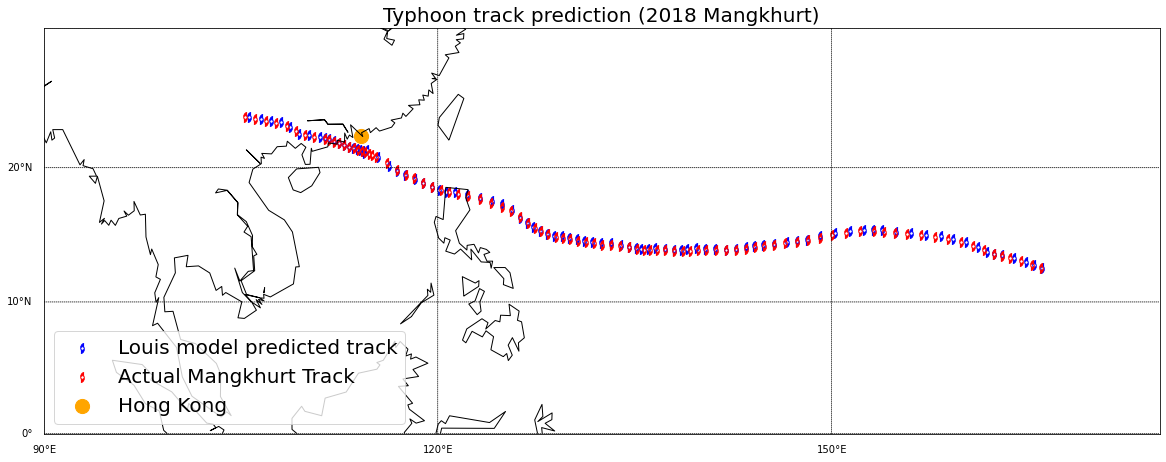

In [148]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 30, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(y_pred_long_MANGKHURT_formatted, y_pred_lat_MANGKHURT_formatted, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(Y_original_MANGKHURT_long, Y_original_MANGKHURT_lat, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual Mangkhurt Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong' )
plt.title('Typhoon track prediction (2018 Mangkhurt)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("2018_MANGKHURT.png")
plt.show()

### 24 hour track error Manghkurt

In [186]:
# y_pred_lat_MANGKHURT_first_lat = model_lat(X_original_MANGKHURT_lat[0][None,:,:].to(device))
# y_pred_long_MANGKHURT_first_long = model_long(X_original_MANGKHURT_long[0][None,:,:].to(device))

# X_original_MANGKHURT_lat[1][4].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_first_lat[0,:].cpu())
# X_original_MANGKHURT_long[1][4].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_first_long[0,:].cpu())


# y_pred_lat_MANGKHURT_second_lat = model_lat(X_original_MANGKHURT_lat[1][None,:,:].to(device))
# y_pred_long_MANGKHURT_second_long = model_long(X_original_MANGKHURT_long[1][None,:,:].to(device))


# X_original_MANGKHURT_lat[2][3].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_first_lat[0,:].cpu())
# X_original_MANGKHURT_lat[2][4].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_second_lat[0,:].cpu())

# X_original_MANGKHURT_long[2][3].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_first_long[0,:].cpu())
# X_original_MANGKHURT_long[2][4].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_second_long[0,:].cpu())

# X_original_MANGKHURT_lat[3][2].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_first_lat[0,:].cpu())
# X_original_MANGKHURT_lat[3][3].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_second_lat[0,:].cpu())

# X_original_MANGKHURT_long[3][2].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_first_long[0,:].cpu())
# X_original_MANGKHURT_long[3][3].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_second_long[0,:].cpu())

# y_pred_lat_MANGKHURT_third_lat = model_lat(X_original_MANGKHURT_lat[2][None,:,:].to(device))
# y_pred_long_MANGKHURT_third_long = model_long(X_original_MANGKHURT_long[2][None,:,:].to(device))


# X_original_MANGKHURT_lat[3][4].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_third_lat[0,:].cpu())
# X_original_MANGKHURT_long[3][4].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_third_long[0,:].cpu())

# X_original_MANGKHURT_lat[4][1].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_first_lat[0,:].cpu())
# X_original_MANGKHURT_lat[4][2].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_second_lat[0,:].cpu())
# X_original_MANGKHURT_lat[4][3].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_third_lat[0,:].cpu())

# X_original_MANGKHURT_long[4][1].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_first_long[0,:].cpu())
# X_original_MANGKHURT_long[4][2].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_second_long[0,:].cpu())
# X_original_MANGKHURT_long[4][3].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_third_long[0,:].cpu())

# y_pred_lat_MANGKHURT_forth_lat = model_lat(X_original_MANGKHURT_lat[3][None,:,:].to(device))
# y_pred_long_MANGKHURT_forth_long = model_long(X_original_MANGKHURT_long[3][None,:,:].to(device))


# X_original_MANGKHURT_lat[4][4].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_forth_lat[0,:].cpu())
# X_original_MANGKHURT_long[4][4].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_forth_long[0,:].cpu())


# X_original_MANGKHURT_lat[5][0].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_first_lat[0,:].cpu())
# X_original_MANGKHURT_lat[5][1].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_second_lat[0,:].cpu())
# X_original_MANGKHURT_lat[5][2].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_third_lat[0,:].cpu())
# X_original_MANGKHURT_lat[5][3].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_forth_lat[0,:].cpu())

# X_original_MANGKHURT_long[5][0].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_first_long[0,:].cpu())
# X_original_MANGKHURT_long[5][1].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_second_long[0,:].cpu())
# X_original_MANGKHURT_long[5][2].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_third_long[0,:].cpu())
# X_original_MANGKHURT_long[5][3].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_forth_long[0,:].cpu())

# y_pred_lat_MANGKHURT_fifth_lat = model_lat(X_original_MANGKHURT_lat[4][None,:,:].to(device))
# y_pred_long_MANGKHURT_fifth_long = model_long(X_original_MANGKHURT_long[4][None,:,:].to(device))


# X_original_MANGKHURT_lat[5][4].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_fifth_lat[0,:].cpu())
# X_original_MANGKHURT_long[5][4].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_fifth_long[0,:].cpu())


# X_original_MANGKHURT_lat[6][0].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_second_lat[0,:].cpu())
# X_original_MANGKHURT_lat[6][1].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_third_lat[0,:].cpu())
# X_original_MANGKHURT_lat[6][2].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_forth_lat[0,:].cpu())
# X_original_MANGKHURT_lat[6][3].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_fifth_lat[0,:].cpu())

# X_original_MANGKHURT_long[6][0].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_second_long[0,:].cpu())
# X_original_MANGKHURT_long[6][1].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_third_long[0,:].cpu())
# X_original_MANGKHURT_long[6][2].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_forth_long[0,:].cpu())
# X_original_MANGKHURT_long[6][3].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_fifth_long[0,:].cpu())

# y_pred_lat_MANGKHURT_sixth_lat = model_lat(X_original_MANGKHURT_lat[5][None,:,:].to(device))
# X_original_MANGKHURT_lat[6][4].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_sixth_lat[0,:].cpu())

# y_pred_long_MANGKHURT_sixth_long = model_long(X_original_MANGKHURT_long[5][None,:,:].to(device))
# X_original_MANGKHURT_long[6][4].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_sixth_long[0,:].cpu())

# X_original_MANGKHURT_lat[7][0].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_third_lat[0,:].cpu())
# X_original_MANGKHURT_lat[7][1].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_forth_lat[0,:].cpu())
# X_original_MANGKHURT_lat[7][2].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_fifth_lat[0,:].cpu())
# X_original_MANGKHURT_lat[7][3].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_sixth_lat[0,:].cpu())

# X_original_MANGKHURT_long[7][0].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_third_long[0,:].cpu())
# X_original_MANGKHURT_long[7][1].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_forth_long[0,:].cpu())
# X_original_MANGKHURT_long[7][2].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_fifth_long[0,:].cpu())
# X_original_MANGKHURT_long[7][3].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_sixth_long[0,:].cpu())

# y_pred_lat_MANGKHURT_seventh_lat = model_lat(X_original_MANGKHURT_lat[6][None,:,:].to(device))
# X_original_MANGKHURT_lat[7][4].index_copy_(0, torch.tensor([0]), y_pred_lat_MANGKHURT_seventh_lat[0,:].cpu())

# y_pred_long_MANGKHURT_seventh_long = model_long(X_original_MANGKHURT_long[6][None,:,:].to(device))
# X_original_MANGKHURT_long[7][4].index_copy_(0, torch.tensor([0]), y_pred_long_MANGKHURT_seventh_long[0,:].cpu())

# y_pred_lat_MANGKHURT_eighth_lat = model_lat(X_original_MANGKHURT_lat[7][None,:,:].to(device))

# y_pred_long_MANGKHURT_eighth_long = model_long(X_original_MANGKHURT_long[7][None,:,:].to(device))

In [187]:
# y_pred_24hour_lat = y_pred_lat_MANGKHURT_eighth_lat.cpu().detach().numpy()

In [188]:
# y_pred_24hour_long = y_pred_long_MANGKHURT_eighth_long.cpu().detach().numpy()

In [189]:
# y_pred_24hour_lat = scaler_lat.inverse_transform(y_pred_24hour_lat)

In [190]:
# y_pred_24hour_long = scaler_long.inverse_transform(y_pred_24hour_long)

In [191]:
# print(math.sqrt(mean_squared_error(Y_original_MANGKHURT_lat[7], y_pred_24hour_lat)))

In [192]:
# print(math.sqrt(mean_squared_error(Y_original_MANGKHURT_long[7], y_pred_24hour_long)))

### Latitude Prediction (2018 KONGREY)

In [148]:
df_features_lat_2018_KONGREY = df_WP_2018_KONGREY[cols_features].astype(float)
df_target_lat_2018_KONGREY = df_WP_2018_KONGREY[cols_target].astype(float)

df_features_lat_2018_KONGREY = df_features_lat_2018_KONGREY[cols_features].to_numpy()
df_target_lat_2018_KONGREY = df_target_lat_2018_KONGREY[cols_target].to_numpy()

X_original_KONGREY_lat=[]
Y_original_KONGREY_lat=[]

for i in range(n_past, len(df_features_lat_2018_KONGREY)-n_future+1):
    X_original_KONGREY_lat.append(df_features_lat_2018_KONGREY[i-n_past:i,0:df_features_lat_2018_KONGREY.shape[1]])
    Y_original_KONGREY_lat.append(df_target_lat_2018_KONGREY[i+n_future-1:i+n_future,0])
    
X_original_KONGREY_lat, Y_original_KONGREY_lat= np.array(X_original_KONGREY_lat), np.array(Y_original_KONGREY_lat)
X_original_KONGREY_lat = torch.from_numpy(X_original_KONGREY_lat).float()
y_pred_lat_KONGREY = model_lat(X_original_KONGREY_lat.to(device))

y_pred_lat_KONGREY  = y_pred_lat_KONGREY.cpu().detach().numpy()
y_pred_lat_KONGREY = scaler_lat.inverse_transform(y_pred_lat_KONGREY)

y_pred_lat_KONGREY_formatted = [ '%.2f' % elem for elem in y_pred_lat_KONGREY ]
y_pred_lat_KONGREY_formatted = [float(i) for i in y_pred_lat_KONGREY_formatted]
print(y_pred_lat_KONGREY_formatted)
print(len(y_pred_lat_KONGREY_formatted))

Y_original_KONGREY_lat = scaler_lat.inverse_transform(Y_original_KONGREY_lat)

# import MSE for accurarcy metrics
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(Y_original_KONGREY_lat, y_pred_lat_KONGREY))
print(math.sqrt(mean_squared_error(Y_original_KONGREY_lat, y_pred_lat_KONGREY)))

[7.58, 8.58, 9.44, 9.68, 10.14, 11.05, 11.89, 12.55, 12.53, 12.62, 12.65, 12.69, 12.86, 13.24, 13.67, 13.82, 14.09, 14.52, 14.86, 15.1, 15.27, 15.39, 15.5, 15.65, 15.83, 16.11, 16.45, 16.87, 17.24, 17.46, 17.63, 17.67, 17.86, 18.2, 18.58, 18.93, 19.32, 19.68, 19.98, 20.16, 20.39, 20.8, 21.19, 21.61, 22.01, 22.43, 22.84, 23.16, 23.64, 24.32, 24.97, 25.49, 26.06, 26.8, 27.4, 27.68, 28.42, 29.15, 30.13, 31.33, 32.53, 32.82, 33.57, 34.7, 36.0, 37.12, 38.08, 38.75, 39.53, 40.83, 41.59, 42.16]
72
0.021775716897968155
0.1475659747298413


### Longitude Prediction (2018 KONGREY)

In [149]:
df_features_long_2018_KONGREY = df_WP_2018_KONGREY[cols_features].astype(float)
df_target_long_2018_KONGREY= df_WP_2018_KONGREY[cols_target_long].astype(float)

df_features_long_2018_KONGREY = df_features_long_2018_KONGREY[cols_features].to_numpy()
df_target_long_2018_KONGREY = df_target_long_2018_KONGREY[cols_target_long].to_numpy()

X_original_2018_KONGREY_long=[]
Y_original_2018_KONGREY_long=[]

for i in range(n_past, len(df_features_long_2018_KONGREY)-n_future+1):
    X_original_2018_KONGREY_long.append(df_features_long_2018_KONGREY[i-n_past:i,0:df_features_long_2018_KONGREY.shape[1]])
    Y_original_2018_KONGREY_long.append(df_target_long_2018_KONGREY[i+n_future-1:i+n_future,0])
    
X_original_2018_KONGREY_long, Y_original_2018_KONGREY_long= np.array(X_original_2018_KONGREY_long), np.array(Y_original_2018_KONGREY_long)    
X_original_2018_KONGREY_long = torch.from_numpy(X_original_2018_KONGREY_long).float()
y_pred_long_2018_KONGREY = model_long(X_original_2018_KONGREY_long.to(device))
y_pred_long_2018_KONGREY  = y_pred_long_2018_KONGREY.cpu().detach().numpy()
y_pred_long_2018_KONGREY = scaler_long.inverse_transform(y_pred_long_2018_KONGREY)

y_pred_long_KONGREY_formatted = [ '%.2f' % elem for elem in y_pred_long_2018_KONGREY ]
y_pred_long_KONGREY_formatted = [float(i) for i in y_pred_long_KONGREY_formatted]
print(y_pred_long_KONGREY_formatted)
print(len(y_pred_long_KONGREY_formatted))

Y_original_2018_KONGREY_long = scaler_long.inverse_transform(Y_original_2018_KONGREY_long)

print(mean_squared_error(Y_original_2018_KONGREY_long, y_pred_long_2018_KONGREY))
print(math.sqrt(mean_squared_error(Y_original_2018_KONGREY_long, y_pred_long_2018_KONGREY)))

[150.63, 149.94, 149.15, 148.3, 147.39, 146.79, 146.04, 145.0, 143.51, 142.32, 141.41, 140.66, 140.14, 139.56, 139.01, 138.65, 138.32, 137.89, 137.46, 137.14, 136.84, 136.48, 136.15, 135.86, 135.57, 135.23, 134.84, 134.42, 133.99, 133.58, 133.17, 132.7, 132.26, 131.95, 131.64, 131.29, 130.88, 130.38, 129.91, 129.6, 129.39, 129.17, 128.97, 128.75, 128.49, 128.15, 127.82, 127.56, 127.33, 127.05, 126.78, 126.5, 126.24, 126.0, 125.78, 125.75, 125.63, 125.73, 125.92, 125.89, 125.84, 126.19, 126.92, 128.21, 129.51, 130.45, 131.5, 133.09, 134.94, 136.65, 138.56, 140.31]
72
0.04245617551497874
0.20604896387746952


In [150]:
pred_2_kong = np.concatenate((y_pred_lat_KONGREY, y_pred_long_2018_KONGREY), axis=1)

In [151]:
true_2_kong = np.concatenate((Y_original_KONGREY_lat, Y_original_2018_KONGREY_long), axis=1)

In [152]:
print(math.sqrt(mean_squared_error(true_2_kong, pred_2_kong)))

0.17920922466902606


### Prediction visualisation (2018 KONGREY)

In [153]:
print("Actual Lat of KONGREY:")
Y_original_KONGREY_lat_formatted = [ '%.2f' % elem for elem in Y_original_KONGREY_lat ]
Y_original_KONGREY_lat_formatted = [float(i) for i in Y_original_KONGREY_lat_formatted]
print(Y_original_KONGREY_lat_formatted)
print(len(Y_original_KONGREY_lat_formatted))
print("Actual Long of KONGREY:")
Y_original_KONGREY_long_formatted = [ '%.2f' % elem for elem in Y_original_2018_KONGREY_long ]
Y_original_KONGREY_long_formatted = [float(i) for i in Y_original_KONGREY_long_formatted]
print(Y_original_KONGREY_long_formatted)
print(len(Y_original_KONGREY_long_formatted))

Actual Lat of KONGREY:
[8.05, 8.8, 9.24, 9.7, 10.42, 11.2, 11.9, 12.2, 12.39, 12.5, 12.58, 12.7, 12.98, 13.3, 13.54, 13.8, 14.15, 14.5, 14.78, 15.0, 15.17, 15.3, 15.43, 15.6, 15.82, 16.1, 16.45, 16.8, 17.08, 17.3, 17.44, 17.6, 17.87, 18.2, 18.54, 18.9, 19.27, 19.6, 19.85, 20.1, 20.43, 20.8, 21.19, 21.6, 22.0, 22.4, 22.77, 23.2, 23.78, 24.4, 24.94, 25.5, 26.15, 26.8, 27.34, 27.9, 28.58, 29.4, 30.41, 31.4, 32.08, 32.8, 33.85, 35.0, 36.09, 37.1, 37.91, 38.7, 39.72, 40.7, 41.43, 42.0]
72
Actual Long of KONGREY:
[150.38, 149.6, 148.8, 148.0, 147.29, 146.5, 145.5, 144.2, 143.1, 142.2, 141.38, 140.7, 140.1, 139.6, 139.19, 138.8, 138.34, 137.9, 137.53, 137.2, 136.84, 136.5, 136.2, 135.9, 135.56, 135.2, 134.81, 134.4, 134.01, 133.6, 133.14, 132.7, 132.34, 132.0, 131.62, 131.2, 130.74, 130.3, 129.97, 129.7, 129.44, 129.2, 128.96, 128.7, 128.4, 128.1, 127.84, 127.6, 127.35, 127.1, 126.85, 126.6, 126.34, 126.1, 125.86, 125.7, 125.72, 125.8, 125.74, 125.8, 126.11, 126.7, 127.58, 128.6, 129.42, 130.

In [154]:
print("Predicted Lat of KONGREY:")
print(y_pred_lat_KONGREY_formatted)
print("----------------------------------------------------------------------------------------------")
print("Predicted Long of KONGREY:")
print(y_pred_long_KONGREY_formatted)

Predicted Lat of KONGREY:
[7.58, 8.58, 9.44, 9.68, 10.14, 11.05, 11.89, 12.55, 12.53, 12.62, 12.65, 12.69, 12.86, 13.24, 13.67, 13.82, 14.09, 14.52, 14.86, 15.1, 15.27, 15.39, 15.5, 15.65, 15.83, 16.11, 16.45, 16.87, 17.24, 17.46, 17.63, 17.67, 17.86, 18.2, 18.58, 18.93, 19.32, 19.68, 19.98, 20.16, 20.39, 20.8, 21.19, 21.61, 22.01, 22.43, 22.84, 23.16, 23.64, 24.32, 24.97, 25.49, 26.06, 26.8, 27.4, 27.68, 28.42, 29.15, 30.13, 31.33, 32.53, 32.82, 33.57, 34.7, 36.0, 37.12, 38.08, 38.75, 39.53, 40.83, 41.59, 42.16]
----------------------------------------------------------------------------------------------
Predicted Long of KONGREY:
[150.63, 149.94, 149.15, 148.3, 147.39, 146.79, 146.04, 145.0, 143.51, 142.32, 141.41, 140.66, 140.14, 139.56, 139.01, 138.65, 138.32, 137.89, 137.46, 137.14, 136.84, 136.48, 136.15, 135.86, 135.57, 135.23, 134.84, 134.42, 133.99, 133.58, 133.17, 132.7, 132.26, 131.95, 131.64, 131.29, 130.88, 130.38, 129.91, 129.6, 129.39, 129.17, 128.97, 128.75, 128.49, 12

In [161]:
hurricane = get_hurricane()

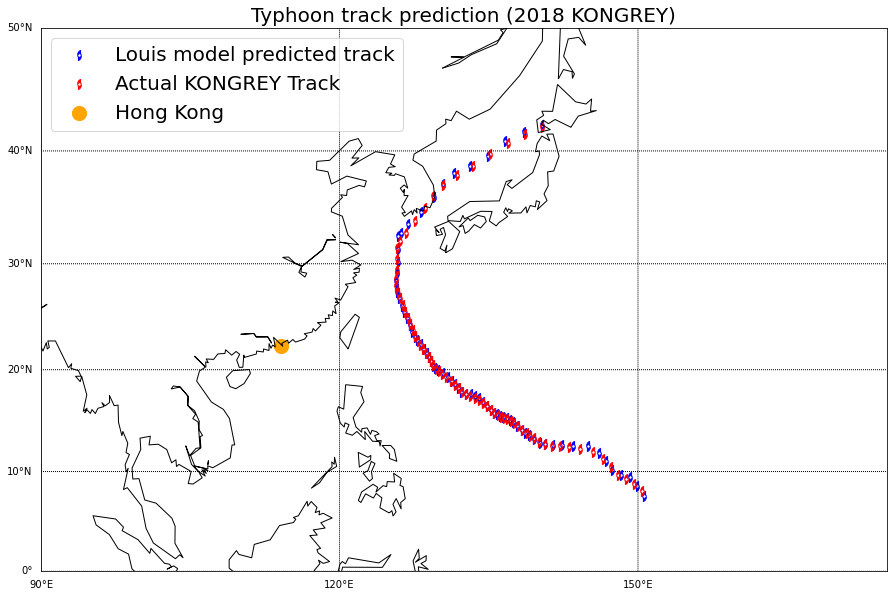

In [162]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 50, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(y_pred_long_KONGREY_formatted, y_pred_lat_KONGREY_formatted, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(Y_original_2018_KONGREY_long, Y_original_KONGREY_lat, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual KONGREY Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong' )
plt.title('Typhoon track prediction (2018 KONGREY)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("2018_KONGREY.png")
plt.show()

### Latitude Prediction (2018 YUTU)

In [163]:
df_features_lat_2018_YUTU = df_WP_2018_YUTU[cols_features].astype(float)
df_target_lat_2018_YUTU = df_WP_2018_YUTU[cols_target].astype(float)

df_features_lat_2018_YUTU = df_features_lat_2018_YUTU[cols_features].to_numpy()
df_target_lat_2018_YUTU = df_target_lat_2018_YUTU[cols_target].to_numpy()

X_original_YUTU_lat=[]
Y_original_YUTU_lat=[]

for i in range(n_past, len(df_features_lat_2018_YUTU)-n_future+1):
    X_original_YUTU_lat.append(df_features_lat_2018_YUTU[i-n_past:i,0:df_features_lat_2018_YUTU.shape[1]])
    Y_original_YUTU_lat.append(df_target_lat_2018_YUTU[i+n_future-1:i+n_future,0])
    
X_original_YUTU_lat, Y_original_YUTU_lat= np.array(X_original_YUTU_lat), np.array(Y_original_YUTU_lat)
X_original_YUTU_lat = torch.from_numpy(X_original_YUTU_lat).float()
y_pred_lat_YUTU = model_lat(X_original_YUTU_lat.to(device))

y_pred_lat_YUTU  = y_pred_lat_YUTU.cpu().detach().numpy()
y_pred_lat_YUTU = scaler_lat.inverse_transform(y_pred_lat_YUTU)

y_pred_lat_YUTU_formatted = [ '%.2f' % elem for elem in y_pred_lat_YUTU ]
y_pred_lat_YUTU_formatted = [float(i) for i in y_pred_lat_YUTU_formatted]
print(y_pred_lat_YUTU_formatted)
print(len(y_pred_lat_YUTU_formatted))

Y_original_YUTU_lat = scaler_lat.inverse_transform(Y_original_YUTU_lat)

# import MSE for accurarcy metrics
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(Y_original_YUTU_lat, y_pred_lat_YUTU))
print(math.sqrt(mean_squared_error(Y_original_YUTU_lat, y_pred_lat_YUTU)))

[8.4, 8.43, 8.51, 8.66, 8.9, 9.25, 9.63, 9.93, 10.22, 10.44, 10.67, 10.91, 11.16, 11.41, 11.69, 11.85, 11.99, 12.02, 12.18, 12.66, 13.11, 13.36, 13.65, 13.94, 14.26, 14.62, 15.01, 15.36, 15.7, 15.93, 16.11, 16.13, 16.17, 16.26, 16.39, 16.57, 16.71, 16.77, 16.89, 17.07, 17.21, 17.27, 17.39, 17.55, 17.7, 17.8, 17.84, 17.86, 17.89, 17.96, 18.01, 17.99, 18.02, 18.01, 18.02, 18.02, 17.99, 17.85, 17.67, 17.53, 17.31, 16.96, 16.76, 16.77, 16.81, 16.84, 16.85, 16.71, 16.7, 16.74, 16.77, 16.72, 16.64, 16.42, 16.43, 16.57, 17.02, 17.22, 17.52, 17.98, 18.29, 18.32, 18.42, 18.77, 19.04, 19.21, 19.44, 19.68, 19.95, 20.16, 20.3, 20.45, 20.55, 20.87, 20.83, 20.83, 20.7, 20.46, 20.27, 20.1, 19.97, 19.93, 19.81, 19.56]
104
0.009243393289197767
0.09614256751927196


### Longitude Prediction (2018 YUTU)

In [164]:
df_features_long_2018_YUTU = df_WP_2018_YUTU[cols_features].astype(float)
df_target_long_2018_YUTU= df_WP_2018_YUTU[cols_target_long].astype(float)

df_features_long_2018_YUTU = df_features_long_2018_YUTU[cols_features].to_numpy()
df_target_long_2018_YUTU = df_target_long_2018_YUTU[cols_target_long].to_numpy()

X_original_2018_YUTU_long=[]
Y_original_2018_YUTU_long=[]

for i in range(n_past, len(df_features_long_2018_YUTU)-n_future+1):
    X_original_2018_YUTU_long.append(df_features_long_2018_YUTU[i-n_past:i,0:df_features_long_2018_YUTU.shape[1]])
    Y_original_2018_YUTU_long.append(df_target_long_2018_YUTU[i+n_future-1:i+n_future,0])
    
X_original_2018_YUTU_long, Y_original_2018_YUTU_long= np.array(X_original_2018_YUTU_long), np.array(Y_original_2018_YUTU_long)    
X_original_2018_YUTU_long = torch.from_numpy(X_original_2018_YUTU_long).float()
y_pred_long_2018_YUTU = model_long(X_original_2018_YUTU_long.to(device))
y_pred_long_2018_YUTU  = y_pred_long_2018_YUTU.cpu().detach().numpy()
y_pred_long_2018_YUTU = scaler_long.inverse_transform(y_pred_long_2018_YUTU)

y_pred_long_YUTU_formatted = [ '%.2f' % elem for elem in y_pred_long_2018_YUTU ]
y_pred_long_YUTU_formatted = [float(i) for i in y_pred_long_YUTU_formatted]
print(y_pred_long_YUTU_formatted)
print(len(y_pred_long_YUTU_formatted))

Y_original_2018_YUTU_long = scaler_long.inverse_transform(Y_original_2018_YUTU_long)

print(mean_squared_error(Y_original_2018_YUTU_long, y_pred_long_2018_YUTU))
print(math.sqrt(mean_squared_error(Y_original_2018_YUTU_long, y_pred_long_2018_YUTU)))

[157.87, 157.47, 157.2, 156.81, 156.34, 155.75, 155.15, 154.77, 154.46, 154.01, 153.57, 153.0, 152.45, 151.81, 151.04, 150.45, 149.95, 149.49, 149.12, 148.84, 148.55, 148.1, 147.6, 147.09, 146.64, 146.21, 145.78, 145.29, 144.77, 144.19, 143.64, 143.14, 142.71, 142.27, 141.85, 141.5, 141.09, 140.44, 139.72, 139.08, 138.44, 137.73, 136.97, 136.17, 135.4, 134.61, 133.84, 133.12, 132.46, 131.91, 131.4, 130.91, 130.4, 129.9, 129.43, 128.92, 128.41, 127.9, 127.41, 126.9, 126.4, 125.9, 125.43, 125.03, 124.59, 124.02, 123.41, 122.81, 122.18, 121.47, 120.77, 120.17, 119.65, 119.1, 118.64, 118.71, 118.54, 118.18, 117.8, 117.52, 117.33, 117.22, 117.12, 116.94, 116.75, 116.59, 116.49, 116.54, 116.64, 116.62, 116.55, 116.49, 116.42, 116.27, 116.29, 116.22, 116.1, 116.25, 116.15, 115.95, 115.77, 115.64, 115.52, 115.42]
104
0.023069205924551712
0.15188550268064333


In [165]:
pred_2_yutu = np.concatenate((y_pred_lat_YUTU, y_pred_long_2018_YUTU), axis=1)

In [166]:
true_2_yutu = np.concatenate((Y_original_YUTU_lat, Y_original_2018_YUTU_long), axis=1)

In [167]:
print(math.sqrt(mean_squared_error(true_2_yutu, pred_2_yutu)))

0.1271074333265948


### Prediction visualisation (2018 YUTU)

In [168]:
print("Actual Lat of YUTU:")
Y_original_YUTU_lat_formatted = [ '%.2f' % elem for elem in Y_original_YUTU_lat ]
Y_original_YUTU_lat_formatted = [float(i) for i in Y_original_YUTU_lat_formatted]
print(Y_original_YUTU_lat_formatted)
print(len(Y_original_YUTU_lat_formatted))
print("Actual Long of YUTU:")
Y_original_YUTU_long_formatted = [ '%.2f' % elem for elem in Y_original_2018_YUTU_long ]
Y_original_YUTU_long_formatted = [float(i) for i in Y_original_YUTU_long_formatted]
print(Y_original_YUTU_long_formatted)
print(len(Y_original_YUTU_long_formatted))

Actual Lat of YUTU:
[8.33, 8.4, 8.51, 8.7, 8.98, 9.3, 9.61, 9.9, 10.16, 10.4, 10.65, 10.9, 11.16, 11.4, 11.62, 11.8, 11.88, 12.0, 12.32, 12.7, 13.01, 13.3, 13.59, 13.9, 14.24, 14.6, 14.96, 15.3, 15.59, 15.8, 15.92, 16.0, 16.09, 16.2, 16.35, 16.5, 16.6, 16.7, 16.85, 17.0, 17.1, 17.2, 17.35, 17.5, 17.61, 17.7, 17.76, 17.8, 17.86, 17.9, 17.91, 17.9, 17.9, 17.9, 17.91, 17.9, 17.82, 17.7, 17.57, 17.4, 17.13, 16.9, 16.81, 16.8, 16.8, 16.8, 16.74, 16.7, 16.75, 16.8, 16.77, 16.7, 16.56, 16.5, 16.65, 16.9, 17.13, 17.4, 17.77, 18.1, 18.26, 18.4, 18.64, 18.9, 19.1, 19.3, 19.55, 19.8, 20.02, 20.2, 20.31, 20.4, 20.57, 20.7, 20.75, 20.7, 20.57, 20.4, 20.24, 20.1, 20.01, 19.9, 19.72, 19.5]
104
Actual Long of YUTU:
[157.97, 157.6, 157.17, 156.7, 156.14, 155.6, 155.19, 154.8, 154.31, 153.8, 153.31, 152.8, 152.21, 151.6, 151.03, 150.5, 150.02, 149.6, 149.25, 148.9, 148.47, 148.0, 147.55, 147.1, 146.66, 146.2, 145.72, 145.2, 144.64, 144.1, 143.63, 143.2, 142.74, 142.3, 141.92, 141.5, 140.93, 140.3, 139.7

In [169]:
print("Predicted Lat of YUTU:")
print(y_pred_lat_YUTU_formatted)
print("----------------------------------------------------------------------------------------------")
print("Predicted Long of YUTU:")
print(y_pred_long_YUTU_formatted)

Predicted Lat of YUTU:
[8.4, 8.43, 8.51, 8.66, 8.9, 9.25, 9.63, 9.93, 10.22, 10.44, 10.67, 10.91, 11.16, 11.41, 11.69, 11.85, 11.99, 12.02, 12.18, 12.66, 13.11, 13.36, 13.65, 13.94, 14.26, 14.62, 15.01, 15.36, 15.7, 15.93, 16.11, 16.13, 16.17, 16.26, 16.39, 16.57, 16.71, 16.77, 16.89, 17.07, 17.21, 17.27, 17.39, 17.55, 17.7, 17.8, 17.84, 17.86, 17.89, 17.96, 18.01, 17.99, 18.02, 18.01, 18.02, 18.02, 17.99, 17.85, 17.67, 17.53, 17.31, 16.96, 16.76, 16.77, 16.81, 16.84, 16.85, 16.71, 16.7, 16.74, 16.77, 16.72, 16.64, 16.42, 16.43, 16.57, 17.02, 17.22, 17.52, 17.98, 18.29, 18.32, 18.42, 18.77, 19.04, 19.21, 19.44, 19.68, 19.95, 20.16, 20.3, 20.45, 20.55, 20.87, 20.83, 20.83, 20.7, 20.46, 20.27, 20.1, 19.97, 19.93, 19.81, 19.56]
----------------------------------------------------------------------------------------------
Predicted Long of YUTU:
[157.87, 157.47, 157.2, 156.81, 156.34, 155.75, 155.15, 154.77, 154.46, 154.01, 153.57, 153.0, 152.45, 151.81, 151.04, 150.45, 149.95, 149.49, 149

In [170]:
hurricane = get_hurricane()

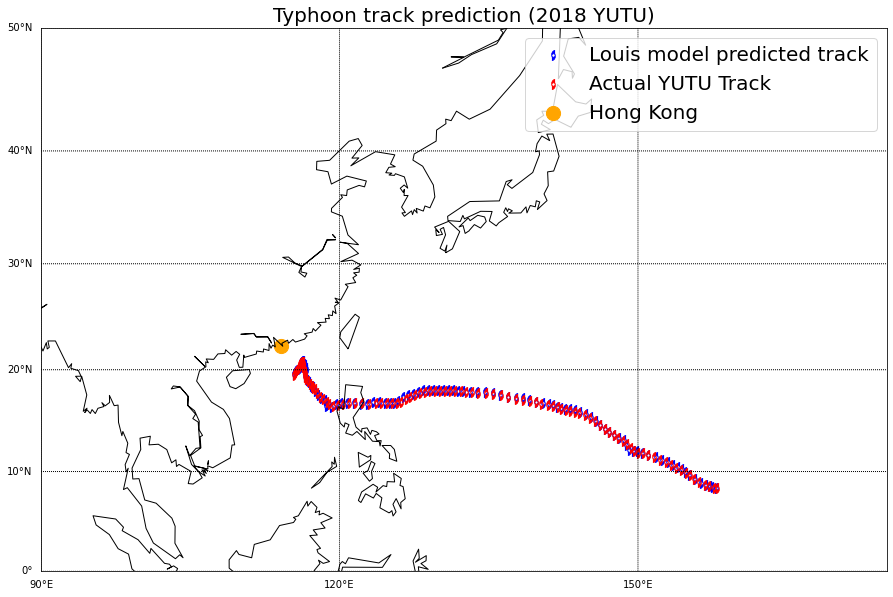

In [171]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 50, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(y_pred_long_YUTU_formatted, y_pred_lat_YUTU_formatted, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(Y_original_2018_YUTU_long, Y_original_YUTU_lat, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual YUTU Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong')
plt.title('Typhoon track prediction (2018 YUTU)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("2018_YUTU.png")
plt.show()

### Latitude Prediction (2019 WUTIP)

In [172]:
df_features_lat_2019_WUTIP = df_WP_2019_WUTIP[cols_features].astype(float)
df_target_lat_2019_WUTIP = df_WP_2019_WUTIP[cols_target].astype(float)

df_features_lat_2019_WUTIP = df_features_lat_2019_WUTIP[cols_features].to_numpy()
df_target_lat_2019_WUTIP = df_target_lat_2019_WUTIP[cols_target].to_numpy()

X_original_WUTIP_lat=[]
Y_original_WUTIP_lat=[]

for i in range(n_past, len(df_features_lat_2019_WUTIP)-n_future+1):
    X_original_WUTIP_lat.append(df_features_lat_2019_WUTIP[i-n_past:i,0:df_features_lat_2019_WUTIP.shape[1]])
    Y_original_WUTIP_lat.append(df_target_lat_2019_WUTIP[i+n_future-1:i+n_future,0])
    
X_original_WUTIP_lat, Y_original_WUTIP_lat= np.array(X_original_WUTIP_lat), np.array(Y_original_WUTIP_lat)
X_original_WUTIP_lat = torch.from_numpy(X_original_WUTIP_lat).float()
y_pred_lat_WUTIP = model_lat(X_original_WUTIP_lat.to(device))

y_pred_lat_WUTIP  = y_pred_lat_WUTIP.cpu().detach().numpy()
y_pred_lat_WUTIP = scaler_lat.inverse_transform(y_pred_lat_WUTIP)

y_pred_lat_WUTIP_formatted = [ '%.2f' % elem for elem in y_pred_lat_WUTIP ]
y_pred_lat_WUTIP_formatted = [float(i) for i in y_pred_lat_WUTIP_formatted]
print(y_pred_lat_WUTIP_formatted)
print(len(y_pred_lat_WUTIP_formatted))

Y_original_WUTIP_lat = scaler_lat.inverse_transform(Y_original_WUTIP_lat)

# import MSE for accurarcy metrics
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(Y_original_WUTIP_lat, y_pred_lat_WUTIP))
print(math.sqrt(mean_squared_error(Y_original_WUTIP_lat, y_pred_lat_WUTIP)))

[5.1, 5.05, 4.92, 4.71, 4.57, 4.6, 4.68, 4.73, 4.84, 5.02, 5.26, 5.34, 5.53, 5.81, 6.08, 6.26, 6.44, 6.65, 6.94, 7.11, 7.38, 7.75, 8.08, 8.3, 8.64, 9.07, 9.51, 9.95, 10.26, 10.34, 10.43, 10.71, 11.04, 11.38, 11.79, 12.25, 12.1, 12.31, 12.44, 12.63, 12.7, 12.79, 12.97, 13.1, 13.08, 13.09, 13.17, 13.26, 13.39, 13.6, 13.87, 14.1, 14.26, 14.49, 14.69, 14.87, 14.97, 15.12, 15.28, 15.43, 15.47, 15.56, 15.63, 15.73, 15.82, 15.98, 16.23, 16.44, 16.38, 16.49, 16.7, 16.87, 17.02, 17.28, 17.44, 17.69, 18.06, 18.36, 18.5, 18.69, 18.94]
81
0.0068316055268642295
0.08265352700801236


### Longitude Prediction (2019 WUTIP)

In [173]:
df_features_long_2019_WUTIP = df_WP_2019_WUTIP[cols_features].astype(float)
df_target_long_2019_WUTIP= df_WP_2019_WUTIP[cols_target_long].astype(float)

df_features_long_2019_WUTIP = df_features_long_2019_WUTIP[cols_features].to_numpy()
df_target_long_2019_WUTIP = df_target_long_2019_WUTIP[cols_target_long].to_numpy()

X_original_2019_WUTIP_long=[]
Y_original_2019_WUTIP_long=[]

for i in range(n_past, len(df_features_long_2019_WUTIP)-n_future+1):
    X_original_2019_WUTIP_long.append(df_features_long_2019_WUTIP[i-n_past:i,0:df_features_long_2019_WUTIP.shape[1]])
    Y_original_2019_WUTIP_long.append(df_target_long_2019_WUTIP[i+n_future-1:i+n_future,0])
    
X_original_2019_WUTIP_long, Y_original_2019_WUTIP_long= np.array(X_original_2019_WUTIP_long), np.array(Y_original_2019_WUTIP_long)    
X_original_2019_WUTIP_long = torch.from_numpy(X_original_2019_WUTIP_long).float()
y_pred_long_2019_WUTIP = model_long(X_original_2019_WUTIP_long.to(device))
y_pred_long_2019_WUTIP  = y_pred_long_2019_WUTIP.cpu().detach().numpy()
y_pred_long_2019_WUTIP = scaler_long.inverse_transform(y_pred_long_2019_WUTIP)

y_pred_long_WUTIP_formatted = [ '%.2f' % elem for elem in y_pred_long_2019_WUTIP ]
y_pred_long_WUTIP_formatted = [float(i) for i in y_pred_long_WUTIP_formatted]
print(y_pred_long_WUTIP_formatted)
print(len(y_pred_long_WUTIP_formatted))

Y_original_2019_WUTIP_long = scaler_long.inverse_transform(Y_original_2019_WUTIP_long)

print(mean_squared_error(Y_original_2019_WUTIP_long, y_pred_long_2019_WUTIP))
print(math.sqrt(mean_squared_error(Y_original_2019_WUTIP_long, y_pred_long_2019_WUTIP)))

[159.03, 158.36, 157.76, 157.05, 156.36, 155.76, 155.24, 154.69, 154.07, 153.57, 153.24, 152.68, 152.11, 151.49, 150.89, 150.38, 149.93, 149.54, 149.19, 148.81, 148.42, 148.01, 147.58, 147.15, 146.68, 146.22, 145.72, 145.19, 144.68, 144.1, 143.64, 143.51, 143.47, 143.26, 142.99, 142.69, 142.64, 142.63, 142.48, 142.23, 142.03, 141.87, 141.69, 141.46, 141.17, 140.88, 140.63, 140.42, 140.25, 140.14, 140.08, 140.06, 140.06, 140.04, 139.89, 139.73, 139.76, 139.83, 139.85, 139.87, 140.03, 140.18, 140.22, 140.18, 140.14, 140.12, 140.07, 139.86, 139.42, 138.77, 137.99, 137.36, 136.87, 136.3, 135.71, 135.18, 134.82, 134.63, 134.53, 134.48, 134.39]
81
0.015890692605323904
0.12605829050611428


In [174]:
pred_2_wutip = np.concatenate((y_pred_lat_WUTIP, y_pred_long_2019_WUTIP), axis=1)

In [175]:
true_2_wutip = np.concatenate((Y_original_WUTIP_lat, Y_original_2019_WUTIP_long), axis=1)

In [182]:
print(math.sqrt(mean_squared_error(true_2_wutip, pred_2_wutip)))

0.10658869107974855


### Prediction visualisation (2019 WUTIP)

In [183]:
print("Actual Lat of WUTIP:")
Y_original_WUTIP_lat_formatted = [ '%.2f' % elem for elem in Y_original_WUTIP_lat ]
Y_original_WUTIP_lat_formatted = [float(i) for i in Y_original_WUTIP_lat_formatted]
print(Y_original_WUTIP_lat_formatted)
print(len(Y_original_WUTIP_lat_formatted))
print("Actual Long of WUTIP:")
Y_original_WUTIP_long_formatted = [ '%.2f' % elem for elem in Y_original_2019_WUTIP_long]
Y_original_WUTIP_long_formatted = [float(i) for i in Y_original_WUTIP_long_formatted]
print(Y_original_WUTIP_long_formatted)
print(len(Y_original_WUTIP_long_formatted))

Actual Lat of WUTIP:
[4.98, 4.9, 4.74, 4.6, 4.57, 4.6, 4.63, 4.7, 4.83, 5.0, 5.13, 5.3, 5.54, 5.8, 6.01, 6.2, 6.39, 6.6, 6.83, 7.1, 7.39, 7.7, 7.98, 8.3, 8.68, 9.1, 9.54, 9.9, 10.07, 10.2, 10.42, 10.7, 11.03, 11.4, 11.8, 11.9, 12.0, 12.2, 12.4, 12.51, 12.6, 12.76, 12.9, 12.97, 13.0, 13.03, 13.1, 13.23, 13.4, 13.59, 13.8, 14.0, 14.2, 14.41, 14.6, 14.76, 14.9, 15.06, 15.2, 15.31, 15.4, 15.5, 15.6, 15.69, 15.8, 16.0, 16.2, 16.31, 16.4, 16.54, 16.7, 16.89, 17.1, 17.29, 17.5, 17.8, 18.1, 18.31, 18.5, 18.74, 19.0]
81
Actual Long of WUTIP:
[159.03, 158.4, 157.69, 157.0, 156.44, 155.9, 155.24, 154.6, 154.09, 153.6, 153.06, 152.5, 151.88, 151.3, 150.82, 150.4, 149.99, 149.6, 149.2, 148.8, 148.41, 148.0, 147.56, 147.1, 146.62, 146.1, 145.54, 145.0, 144.5, 144.1, 143.87, 143.7, 143.45, 143.2, 142.96, 142.9, 142.8, 142.6, 142.4, 142.25, 142.1, 141.92, 141.7, 141.4, 141.1, 140.88, 140.7, 140.53, 140.4, 140.28, 140.2, 140.15, 140.1, 139.99, 139.9, 139.88, 139.9, 139.88, 139.9, 140.0, 140.1, 140.12, 

In [184]:
print("Predicted Lat of WUTIP:")
print(y_pred_lat_WUTIP_formatted)
print("----------------------------------------------------------------------------------------------")
print("Predicted Long of WUTIP:")
print(y_pred_long_WUTIP_formatted)

Predicted Lat of WUTIP:
[5.1, 5.05, 4.92, 4.71, 4.57, 4.6, 4.68, 4.73, 4.84, 5.02, 5.26, 5.34, 5.53, 5.81, 6.08, 6.26, 6.44, 6.65, 6.94, 7.11, 7.38, 7.75, 8.08, 8.3, 8.64, 9.07, 9.51, 9.95, 10.26, 10.34, 10.43, 10.71, 11.04, 11.38, 11.79, 12.25, 12.1, 12.31, 12.44, 12.63, 12.7, 12.79, 12.97, 13.1, 13.08, 13.09, 13.17, 13.26, 13.39, 13.6, 13.87, 14.1, 14.26, 14.49, 14.69, 14.87, 14.97, 15.12, 15.28, 15.43, 15.47, 15.56, 15.63, 15.73, 15.82, 15.98, 16.23, 16.44, 16.38, 16.49, 16.7, 16.87, 17.02, 17.28, 17.44, 17.69, 18.06, 18.36, 18.5, 18.69, 18.94]
----------------------------------------------------------------------------------------------
Predicted Long of WUTIP:
[159.03, 158.36, 157.76, 157.05, 156.36, 155.76, 155.24, 154.69, 154.07, 153.57, 153.24, 152.68, 152.11, 151.49, 150.89, 150.38, 149.93, 149.54, 149.19, 148.81, 148.42, 148.01, 147.58, 147.15, 146.68, 146.22, 145.72, 145.19, 144.68, 144.1, 143.64, 143.51, 143.47, 143.26, 142.99, 142.69, 142.64, 142.63, 142.48, 142.23, 142.03

In [185]:
hurricane = get_hurricane()

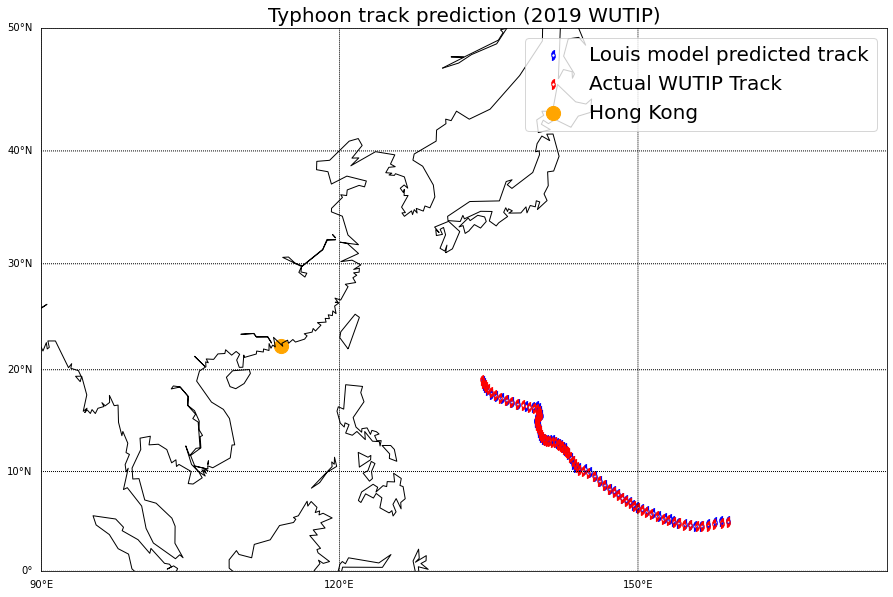

In [186]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 50, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(y_pred_long_WUTIP_formatted, y_pred_lat_WUTIP_formatted, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(Y_original_2019_WUTIP_long, Y_original_WUTIP_lat, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual WUTIP Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong')
plt.title('Typhoon track prediction (2019 WUTIP)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("2019_WUTIP.png")
plt.show()